In [1]:
import numpy as np
import pandas as pd
import librosa

import os
import time
import re
from tqdm import tqdm
import h5py

import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model

import matplotlib.pyplot as plt
import IPython.display
import librosa.display

import ESC

# Use GPU
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3769344547785098055
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2617929073012433212
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7046801664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9272413529168062530
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2869875342047293726
physical_device_desc: "device: XLA_GPU device"
]


## Define the Network

In [2]:
PiczakNet = ESC.PiczakNet([60, 41, 2])

print(PiczakNet.summary())

plot_model(PiczakNet, show_shapes=True, show_layer_names=True)

opt = tf.keras.optimizers.Adam(lr=0.0002)
PiczakNet.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

Model: "PiczakNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60, 41, 2)]       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 60, 41, 80)        54800     
_________________________________________________________________
activation (Activation)      (None, 60, 41, 80)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 14, 80)        0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 14, 80)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 60, 14, 80)        19280     
_________________________________________________________________
activation_1 (Activation)    (None, 60, 14, 80)        0 

## Load Data

In [3]:
# Load
af1, alf1 = ESC.Load_Augmented(name='af1', path='Augmented_2/')
af2, alf2 = ESC.Load_Augmented(name='af2', path='Augmented_2/')
af3, alf3 = ESC.Load_Augmented(name='af3', path='Augmented_2/')
af4, alf4 = ESC.Load_Augmented(name='af4', path='Augmented_2/')
af5, alf5 = ESC.Load_Augmented(name='af5', path='Augmented_2/')

In [5]:
# Compute the features
f1_processed, lf1_processed = ESC.Preprocessing(af1, alf1)
f2_processed, lf2_processed = ESC.Preprocessing(af2, alf2)
f3_processed, lf3_processed = ESC.Preprocessing(af3, alf3)
f4_processed, lf4_processed = ESC.Preprocessing(af4, alf4)
f5_processed, lf5_processed = ESC.Preprocessing(af5, alf5)

100%|██████████| 2000/2000 [00:13<00:00, 147.54it/s]


In [6]:
print('Shape f1: ', f1_processed.shape)
print('Shape f2: ', f2_processed.shape)
print('Shape f2: ', f3_processed.shape)
print('Shape f4: ', f4_processed.shape)
print('Shape f5: ', f5_processed.shape)

Shape f1:  (18000, 60, 41, 2)
Shape f2:  (18000, 60, 41, 2)
Shape f2:  (18000, 60, 41, 2)
Shape f4:  (18000, 60, 41, 2)
Shape f5:  (18000, 60, 41, 2)


In [7]:
# Generate training and validation set

training_dataset = ESC.CreateTrainingSet(f4_processed, f5_processed, f3_processed, lf4_processed, lf5_processed, lf3_processed)

validation_dataset = ESC.CreateValidationSet(f1_processed, lf1_processed)

In [8]:
max_epochs = 30

epoch_loss= []
epoch_acc = []

epoch_vl = []
epoch_va = []

# Loop over the epochs
for epoch in range(max_epochs):
    
    step_loss = []
    step_acc = []
    
    step_vl = []
    step_va = []
    
    start = time.time()
    # train over mini-batches
    for x_batch, y_batch in training_dataset:
        
        # train on batch
        step_stats = PiczakNet.train_on_batch(x_batch, y_batch)
        
        # save loss and accuracy
        step_loss.append(step_stats[0])
        step_acc.append(step_stats[1])
        
    # compute validation stats
    for x_batch, y_batch in validation_dataset:
        
        # compute validation stats
        val_stats = PiczakNet.test_on_batch(x_batch, y_batch)
        
        # save loss and accuracy
        step_vl.append(val_stats[0])
        step_va.append(val_stats[1])
    end = time.time()
        
    # Save the mean loss and accuracy of the entire epoch
    epoch_loss.append(np.mean(step_loss))
    epoch_acc.append(np.mean(step_acc))
    epoch_vl.append(np.mean(step_vl))
    epoch_va.append(np.mean(step_va))
    
    # Print epoch training stats
    print("Epoch %2d: \t t-loss: %3.6f \t t-acc: %.6f \t v-loss: %3.6f \t v-acc: %.6f \t time: %3.3f" % (epoch + 1, epoch_loss[-1], epoch_acc[-1], epoch_vl[-1], epoch_va[-1], (end - start)))

Epoch  1: 	 t-loss: 28.867177 	 t-acc: 0.203810 	 v-loss: 7.713114 	 v-acc: 0.214032 	 time: 182.975
Epoch  2: 	 t-loss: 4.943612 	 t-acc: 0.348545 	 v-loss: 4.397739 	 v-acc: 0.254107 	 time: 169.249
Epoch  3: 	 t-loss: 3.525956 	 t-acc: 0.400548 	 v-loss: 3.896870 	 v-acc: 0.273146 	 time: 168.562
Epoch  4: 	 t-loss: 3.292401 	 t-acc: 0.425355 	 v-loss: 3.894896 	 v-acc: 0.284414 	 time: 168.258
Epoch  5: 	 t-loss: 3.210269 	 t-acc: 0.449034 	 v-loss: 3.826538 	 v-acc: 0.302731 	 time: 168.154
Epoch  6: 	 t-loss: 3.166631 	 t-acc: 0.462585 	 v-loss: 3.844304 	 v-acc: 0.297902 	 time: 168.628
Epoch  7: 	 t-loss: 3.120884 	 t-acc: 0.473693 	 v-loss: 3.852624 	 v-acc: 0.301288 	 time: 168.750
Epoch  8: 	 t-loss: 3.069788 	 t-acc: 0.488911 	 v-loss: 3.890622 	 v-acc: 0.295182 	 time: 168.922
Epoch  9: 	 t-loss: 3.032033 	 t-acc: 0.492280 	 v-loss: 3.830441 	 v-acc: 0.300178 	 time: 167.937
Epoch 10: 	 t-loss: 3.020779 	 t-acc: 0.499463 	 v-loss: 3.831096 	 v-acc: 0.309836 	 time: 168.456

In [ ]:
'''
max_epochs = 50
train_steps = int(np.ceil(len(f1_processed)/32))
val_steps = int(np.ceil(len(f2_processed)/32))

history = PiczakNet.fit(training_dataset,
                        epochs=max_epochs, 
                        validation_data=validation_dataset, 
                        validation_steps=val_steps,
                        steps_per_epoch=train_steps)
# Plot loss
plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
'''

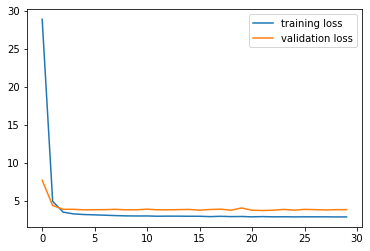

In [9]:
plt.figure()
plt.plot(epoch_loss, label='training loss')
plt.plot(epoch_vl, label='validation loss')
plt.legend()
plt.show()
plt.close('all')

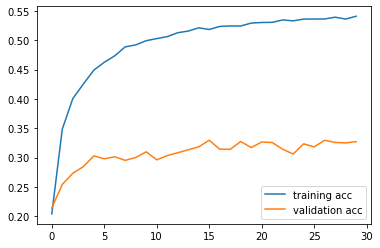

In [10]:
plt.figure()
plt.plot(epoch_acc, label='training acc')
plt.plot(epoch_va, label='validation acc')
plt.legend()
plt.show()
plt.close('all')

## Test on Other Folds

In [11]:
PiczakNet.evaluate(f3_processed, lf3_processed)

563/563 [==============================] - 11s 19ms/step - loss: 2.7730 - accuracy: 0.5855


[2.773038387298584, 0.5855000019073486]

In [12]:
PiczakNet.evaluate(f1_processed, lf1_processed)

563/563 [==============================] - 11s 19ms/step - loss: 3.8527 - accuracy: 0.3267


[3.852735757827759, 0.32672223448753357]

In [13]:
PiczakNet.evaluate(f2_processed, lf2_processed)

563/563 [==============================] - 11s 19ms/step - loss: 3.6950 - accuracy: 0.3543


[3.694983959197998, 0.3543333411216736]

In [14]:
PiczakNet.evaluate(f4_processed, lf4_processed)

563/563 [==============================] - 11s 19ms/step - loss: 2.6666 - accuracy: 0.6327


[2.666583299636841, 0.6327221989631653]

In [15]:
PiczakNet.evaluate(f5_processed, lf5_processed)

563/563 [==============================] - 11s 19ms/step - loss: 2.7209 - accuracy: 0.6033


[2.7208876609802246, 0.6033333539962769]

## Predict

In [ ]:
print(f4_processed[0].shape)

input_sample = np.expand_dims(f4_processed[0], axis=0)

print(input_sample.shape)

In [ ]:
prediction = PiczakNet.predict(input_sample)

In [ ]:
print(prediction)
plt.figure()
plt.plot(prediction[0], '.')
plt.show()

In [ ]:
category = np.argmax(prediction, axis=1)
print(category)

print(lf4_processed.shape)
label_category = np.argmax(lf4_processed[0], axis=0)
print(label_category)

In [ ]:
plt.figure()
plt.plot(lf4_processed[0], '.')
plt.show()

In [ ]:
IPython.display.Audio(af4[0], rate=22050)